In [1]:
%pip install scikit-image==0.24.0
%pip install nibabel==5.2.1
%pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 72.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-image
    Found existing installation: scikit-image 0.25.2
    Uninstalling scikit-image-0.25.2:
      Successfully uninstalled scikit-image-0.25.2
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 19.9 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: nibabel
    Found existing installation: nibabel 5.3.2
    Uninstalling nibabel-5.3.2:
      Successfully uninstalled nibabel-5.3.2
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
# from skimage.util import montage 
# import skimage.transform as skTrans
# from skimage.transform import rotate
# from skimage.transform import resize
# from PIL import Image, ImageOps  
import nibabel as nib
import requests
import zipfile
import io
import os


In [3]:

extract_dir = "extracted_files"
if not os.path.exists(extract_dir):
    url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/EFOEudjvmSIMYp700qwtrg/dataset.zip'

    response = requests.get(url)
    zip_file = io.BytesIO(response.content)

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Extract all contents to a specific directory
        zip_ref.extractall("extracted_files")

extracted_files = os.listdir("extracted_files")
print("Extracted files:", extracted_files)

TRAIN_DATASET_PATH = 'extracted_files/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'extracted_files/dataset/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'


Extracted files: ['dataset']


Text(0.5, 1.0, 'Mask')

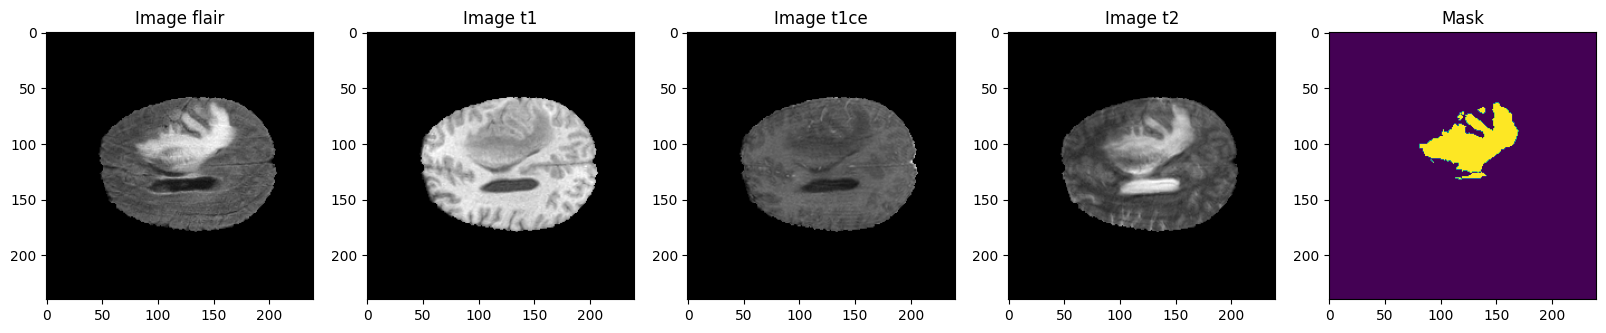

In [4]:
test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

In [7]:
import torch
import torch.nn as nn

def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return conv_op
class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        # Expanding path
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)
        
        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )
    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)

        up_1 = self.up_transpose_1(down_9)
        up_2 = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_3 = self.up_transpose_2(up_2)
        up_4 = self.up_convolution_2(torch.cat([down_5, up_3], 1))
        up_5 = self.up_transpose_3(up_4)
        up_6 = self.up_convolution_3(torch.cat([down_3, up_5], 1))
        up_7 = self.up_transpose_4(up_6)
        up_8 = self.up_convolution_4(torch.cat([down_1, up_7], 1))

        out = self.out(up_8)

        return out

In [8]:
model = UNet(num_classes=1)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

model.to(device)

from sklearn.model_selection import train_test_split
import os

# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.3, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.3, random_state=42)

print(f"Train: {len(train_ids)} | Validation: {len(val_ids)} | Test: {len(test_ids)}")

cpu
Train: 9 | Validation: 6 | Test: 5


In [9]:
def load_dataset(ids, path):
    images = np.zeros((len(ids)*10, 240, 240), np.float32)
    masks = np.zeros((len(ids)*10, 240, 240), np.float32)

    i = 0
    for id in ids:
        t2 = nib.load(f"{path}{id}/{id}_t2.nii").get_fdata()
        seg = nib.load(f"{path}{id}/{id}_seg.nii").get_fdata()

        for s in range(50, seg.shape[2]-50, 10):
            images[i] = t2[:, :, s] / t2.max()
            masks[i] = seg[:, :, s] > 0
            i += 1

    images = np.expand_dims(images[:i], axis=1)
    masks = np.expand_dims(masks[:i], axis=1)

    return images, masks

train_images, train_masks = load_dataset(train_ids, TRAIN_DATASET_PATH)
val_images, val_masks = load_dataset(val_ids, TRAIN_DATASET_PATH)

train_images.shape, val_masks.shape

((54, 1, 240, 240), (36, 1, 240, 240))

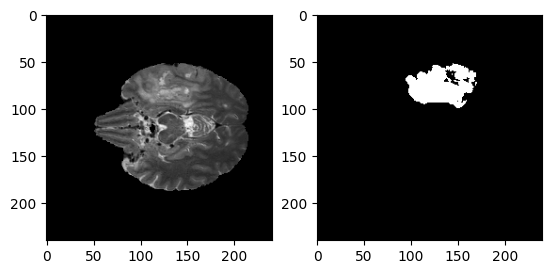

In [10]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

train_dataset = TensorDataset(torch.from_numpy(train_images).type(torch.float32), torch.from_numpy(train_masks).type(torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.from_numpy(val_images).type(torch.float32), torch.from_numpy(val_masks).type(torch.float32))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, Y = next(iter(train_dataloader))
plt.subplot(121)
plt.imshow(X[0, 0], cmap='gray')
plt.subplot(122)
plt.imshow(Y[0, 0], cmap='gray')

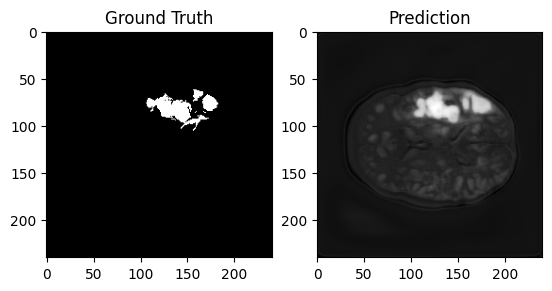

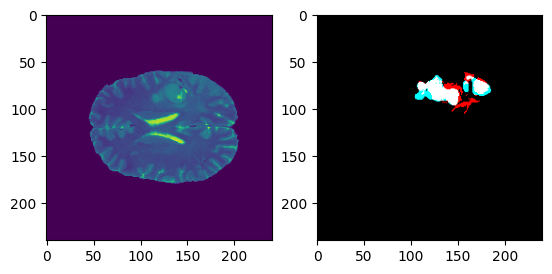

In [11]:
import torch
import requests
import zipfile
import io
import os


checkpoint_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HATpl02lA0ykn9aAU9K6sA/checkpoint-epoch-29.pt'
local_checkpoint_path = 'checkpoint-epoch-29.pt'

if not os.path.exists(local_checkpoint_path):
    response = requests.get(checkpoint_url)
    # Save the downloaded file locally
    with open(local_checkpoint_path, 'wb') as f:
        f.write(response.content)

# Load the checkpoint
checkpoint = torch.load(local_checkpoint_path, map_location=torch.device('cpu'))

# Reinitialize the model architecture
model = UNet(num_classes=1).to(torch.device('cpu'))
# Load the model state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

X, y = next(iter(test_dataloader))
X, y = X.to(torch.device('cpu')), y.to(torch.device('cpu'))

with torch.inference_mode():
    y_pred = model(X)
    y1 = y[3, 0].cpu().detach().numpy()
y2 = y_pred[3, 0].cpu().detach().numpy()
plt.subplot(121)
plt.imshow(y1, cmap='gray')
plt.title('Ground Truth')
plt.subplot(122)
plt.imshow(y2, cmap='gray')
plt.title('Prediction')
plt.show()


y_color = np.zeros((*y1.shape, 3))
y_color[..., 0] = y1
y_color[..., 1] = y2
y_color[..., 2] = y2


plt.subplot(121)
plt.imshow(X[4, 0].cpu().detach().numpy())
plt.subplot(122)
plt.imshow(y_color)

In [12]:
import torch
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm import tqdm

# --- helpers ---
def dice_coefficient(y_true, y_pred, eps=1e-7):
    # y_true, y_pred as binary (0/1) numpy arrays
    intersection = (y_true * y_pred).sum()
    return (2.0 * intersection + eps) / (y_true.sum() + y_pred.sum() + eps)

def iou_score(y_true, y_pred, eps=1e-7):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    return (intersection + eps) / (union + eps)

# set model to eval mode
model.eval()
device = next(model.parameters()).device  # cpu or cuda
all_true = []
all_pred = []

dice_per_image = []
iou_per_image  = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc="Evaluating"):
        # batch should be (images, masks)
        X, Y = batch  # X: (B, C, H, W), Y: (B, 1, H, W) or (B, H, W)
        X = X.to(device)

        logits = model(X)  # (B, 1, H, W)
        # sigmoid -> threshold
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()

        # move to cpu numpy
        y_true = Y.detach().cpu().numpy()
        y_pred = preds.detach().cpu().numpy()

        # ensure shape is (B, H, W)
        if y_true.ndim == 4 and y_true.shape[1] == 1:
            y_true = y_true[:, 0, ...]
        if y_pred.ndim == 4 and y_pred.shape[1] == 1:
            y_pred = y_pred[:, 0, ...]

        # per-image dice/iou
        for i in range(y_true.shape[0]):
            yt = (y_true[i] > 0.5).astype(np.uint8)
            yp = (y_pred[i] > 0.5).astype(np.uint8)
            dice_per_image.append(dice_coefficient(yt, yp))
            iou_per_image.append(iou_score(yt, yp))

        # flatten for classification report
        all_true.append((y_true > 0.5).astype(np.uint8).ravel())
        all_pred.append((y_pred > 0.5).astype(np.uint8).ravel())

# concat all pixels
all_true = np.concatenate(all_true)
all_pred = np.concatenate(all_pred)

# metrics
overall_acc = accuracy_score(all_true, all_pred)
cm = confusion_matrix(all_true, all_pred, labels=[0, 1])
report = classification_report(all_true, all_pred, target_names=["background", "tumor"], digits=4)

print("=== Pixel-wise Evaluation on Test Set (Binary) ===")
print(f"Accuracy: {overall_acc:.4f}")
print("Confusion Matrix [rows=true, cols=pred] (labels: 0=background, 1=tumor):")
print(cm)
print("\nClassification Report:")
print(report)

print(f"\nMean Dice (per image): {np.mean(dice_per_image):.4f} ± {np.std(dice_per_image):.4f}")
print(f"Mean IoU  (per image): {np.mean(iou_per_image):.4f} ± {np.std(iou_per_image):.4f}")


Evaluating: 100%|██████████| 5/5 [00:38<00:00,  7.65s/it]


=== Pixel-wise Evaluation on Test Set (Binary) ===
Accuracy: 0.9930
Confusion Matrix [rows=true, cols=pred] (labels: 0=background, 1=tumor):
[[2010537    3670]
 [  10896   48497]]

Classification Report:
              precision    recall  f1-score   support

  background     0.9946    0.9982    0.9964   2014207
       tumor     0.9296    0.8165    0.8694     59393

    accuracy                         0.9930   2073600
   macro avg     0.9621    0.9074    0.9329   2073600
weighted avg     0.9927    0.9930    0.9928   2073600


Mean Dice (per image): 0.8021 ± 0.2379
Mean IoU  (per image): 0.7186 ± 0.2531
